In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
import numpy as np
import numpy.matlib
from PIL import Image
import PIL
from torchvision import transforms
import torch.nn.functional as F
from modules import *

from matplotlib import pyplot as plt
from unet import UNet
from resnet import ResNet
from torch.autograd import Variable
import cv2
import imageio

In [2]:
def featureL2Norm(feature):
    epsilon = 1e-6
    #        print(feature.size())
    #        print(torch.pow(torch.sum(torch.pow(feature,2),1)+epsilon,0.5).size())
    norm = torch.pow(torch.sum(torch.pow(feature,2),1)+epsilon,0.5).unsqueeze(1).expand_as(feature)
    return torch.div(feature,norm)

In [3]:

class FeatureExtraction(torch.nn.Module):
    def __init__(self, train_fe=False, feature_extraction_cnn='vgg', normalization=True, last_layer='', use_cuda=True):
        super(FeatureExtraction, self).__init__()
        self.normalization = normalization
        if feature_extraction_cnn == 'vgg':
            self.model = models.vgg16(pretrained=True)
            # keep feature extraction network up to indicated layer
            vgg_feature_layers=['conv1_1','relu1_1','conv1_2','relu1_2','pool1','conv2_1',
                         'relu2_1','conv2_2','relu2_2','pool2','conv3_1','relu3_1',
                         'conv3_2','relu3_2','conv3_3','relu3_3','pool3','conv4_1',
                         'relu4_1','conv4_2','relu4_2','conv4_3','relu4_3','pool4',
                         'conv5_1','relu5_1','conv5_2','relu5_2','conv5_3','relu5_3','pool5']
            if last_layer=='':
                last_layer = 'pool4'
            last_layer_idx = vgg_feature_layers.index(last_layer)
            self.model = nn.Sequential(*list(self.model.features.children())[:last_layer_idx+1])
        if feature_extraction_cnn == 'resnet101':
            self.model = models.resnet101(pretrained=True)
            resnet_feature_layers = ['conv1',
                                     'bn1',
                                     'relu',
                                     'maxpool',
                                     'layer1',
                                     'layer2',
                                     'layer3',
                                     'layer4']
            if last_layer=='':
                last_layer = 'layer3'
            last_layer_idx = resnet_feature_layers.index(last_layer)
            resnet_module_list = [self.model.conv1,
                                  self.model.bn1,
                                  self.model.relu,
                                  self.model.maxpool,
                                  self.model.layer1,
                                  self.model.layer2,
                                  self.model.layer3,
                                  self.model.layer4]
            
            self.model = nn.Sequential(*resnet_module_list[:last_layer_idx+1])
        if feature_extraction_cnn == 'resnet101_v2':
            self.model = models.resnet101(pretrained=True)
            # keep feature extraction network up to pool4 (last layer - 7)
            self.model = nn.Sequential(*list(self.model.children())[:-3])
        if feature_extraction_cnn == 'densenet201':
            self.model = models.densenet201(pretrained=True)
            # keep feature extraction network up to denseblock3
            # self.model = nn.Sequential(*list(self.model.features.children())[:-3])
            # keep feature extraction network up to transitionlayer2
            self.model = nn.Sequential(*list(self.model.features.children())[:-4])
        if not train_fe:
            # freeze parameters
            for param in self.model.parameters():
                param.requires_grad = False
        # move to GPU
        if use_cuda:
            self.model = self.model.cuda()
        
    def forward(self, image_batch):
        features = self.model(image_batch)
        if self.normalization:
            features = featureL2Norm(features)
        return features

In [20]:

def get_net(input_depth, NET_TYPE, pad, upsample_mode, n_channels=3, act_fun='LeakyReLU', skip_n33d=128, skip_n33u=128, skip_n11=4, num_scales=5, downsample_mode='stride'):
    if NET_TYPE == 'ResNet':
        # TODO
        net = ResNet(input_depth, 2, 10, 16, 1, nn.BatchNorm2d, False)
    elif NET_TYPE == 'skip':
        net = skip(input_depth, n_channels, num_channels_down = [skip_n33d]*num_scales if isinstance(skip_n33d, int) else skip_n33d,
                                            num_channels_up =   [skip_n33u]*num_scales if isinstance(skip_n33u, int) else skip_n33u,
                                            num_channels_skip = [skip_n11]*num_scales if isinstance(skip_n11, int) else skip_n11, 
                                            upsample_mode=upsample_mode, downsample_mode=downsample_mode,
                                            need_sigmoid=True, need_bias=True, pad=pad, act_fun=act_fun)

    elif NET_TYPE == 'texture_nets':
        net = get_texture_nets(inp=input_depth, ratios = [32, 16, 8, 4, 2, 1], fill_noise=False,pad=pad)

    elif NET_TYPE =='UNet':
        net = UNet(num_input_channels=input_depth, num_output_channels=2, 
                   feature_scale=4, more_layers=0, concat_x=False,
                   upsample_mode=upsample_mode, pad=pad, norm_layer=nn.BatchNorm2d, need_sigmoid=True, need_bias=True)
    elif NET_TYPE == 'identity':
        assert input_depth == 3
        net = nn.Sequential()
    else:
        assert False

    return net

In [5]:
def fill_noise(x, noise_type):
    """Fills tensor `x` with noise of type `noise_type`."""
    if noise_type == 'u':
        x.uniform_()
    elif noise_type == 'n':
        x.normal_() 
    else:
        assert False

def get_noise(input_depth, method, spatial_size, noise_type='u', var=1./10):
    """Returns a pytorch.Tensor of size (1 x `input_depth` x `spatial_size[0]` x `spatial_size[1]`) 
    initialized in a specific way.
    Args:
        input_depth: number of channels in the tensor
        method: `noise` for fillting tensor with noise; `meshgrid` for np.meshgrid
        spatial_size: spatial size of the tensor to initialize
        noise_type: 'u' for uniform; 'n' for normal
        var: a factor, a noise will be multiplicated by. Basically it is standard deviation scaler. 
    """
    if isinstance(spatial_size, int):
        spatial_size = (spatial_size, spatial_size)
    if method == 'noise':
        shape = [1, input_depth, spatial_size[0], spatial_size[1]]
        net_input = torch.zeros(shape)
        
        fill_noise(net_input, noise_type)
        net_input *= var            
    elif method == 'meshgrid': 
        assert input_depth == 2
        X, Y = np.meshgrid(np.arange(0, spatial_size[1])/float(spatial_size[1]-1), np.arange(0, spatial_size[0])/float(spatial_size[0]-1))
        meshgrid = np.concatenate([X[None,:], Y[None,:]])
        net_input=  np_to_torch(meshgrid)
    else:
        assert False
        
    return net_input

In [6]:
#Closure is for loss
dtype = torch.cuda.FloatTensor
mse = torch.nn.MSELoss().type(dtype)
def optimize(optimizer_type, parameters, closure, LR, num_iter):
    """Runs optimization loop.
    Args:
        optimizer_type: 'LBFGS' of 'adam'
        parameters: list of Tensors to optimize over
        closure: function, that returns loss variable
        LR: learning rate
        num_iter: number of iterations 
    """
    if optimizer_type == 'LBFGS':
        # Do several steps with adam first
        optimizer = torch.optim.Adam(parameters, lr=0.001)
        for j in range(100):
            optimizer.zero_grad()
            closure()
            optimizer.step()

        print('Starting optimization with LBFGS')        
        def closure2():
            optimizer.zero_grad()
            return closure()
        optimizer = torch.optim.LBFGS(parameters, max_iter=num_iter, lr=LR, tolerance_grad=-1, tolerance_change=-1)
        optimizer.step(closure2)

    elif optimizer_type == 'adam':
        print('Starting optimization with ADAM')
        optimizer = torch.optim.Adam(parameters, lr=LR)
        
        for j in range(num_iter):
            optimizer.zero_grad()
            closure()
            optimizer.step()
    else:
        assert False

In [7]:
def warp3(x, flo):
    """
  #Matching_image_field[:,0,:,:]=2*Matching_image_field[:,0,:,:]-1
    #Matching_image_field[:,1,:,:]=2*Matching_image_field[:,1,:,:]-1
    #Matching_image_field=Matching_image_field.transpose(1,2).transpose(2,3)
    #Warped_image=F.grid_sample(I1,Matching_image_field.cuda())
    
    """
    flo[:,0,:,:]=2*flo[:,0,:,:]-1
    flo[:,1,:,:]=2*flo[:,1,:,:]-1
    flo=flo.transpose(1,2).transpose(2,3)
    output=F.grid_sample(x.detach(),flo)
    # makes a mapping out of the flow

    # scale grid to [-1,1]
   
    

    return output 

In [8]:
def warp5(x, flo):
    """
    warp an image/tensor (im2) back to im1, according to the optical flow
    x: [B, C, H, W] (im2)
    flo: [B, 2, H, W] flow
    """
    B, C, H, W = x.size()
    # mesh grid
    xx = torch.arange(0, W).view(1, -1).repeat(H, 1)
    yy = torch.arange(0, H).view(-1, 1).repeat(1, W)
    xx = xx.view(1, 1, H, W).repeat(B, 1, 1, 1)
    yy = yy.view(1, 1, H, W).repeat(B, 1, 1, 1)
    grid = torch.cat((xx, yy), 1).float()

    if x.is_cuda:
        grid = grid.cuda()
    vgrid = Variable(grid) + flo
    # makes a mapping out of the flow

    # scale grid to [-1,1]
    vgrid[:, 0, :, :] = 2.0 * vgrid[:, 0, :, :].clone() / max(W - 1, 1) - 1.0
    vgrid[:, 1, :, :] = 2.0 * vgrid[:, 1, :, :].clone() / max(H - 1, 1) - 1.0

    vgrid = vgrid.permute(0, 2, 3, 1)
    output = nn.functional.grid_sample(x, vgrid)
    

    return output 

In [9]:
def get_params(opt_over, net, net_input, downsampler=None):
    '''Returns parameters that we want to optimize over.
    Args:
        opt_over: comma separated list, e.g. "net,input" or "net"
        net: network
        net_input: torch.Tensor that stores input `z`
    '''
    opt_over_list = opt_over.split(',')
    params = []
    
    for opt in opt_over_list:
    
        if opt == 'net':
            params += [x for x in net.parameters() ]
        elif  opt=='down':
            assert downsampler is not None
            params = [x for x in downsampler.parameters()]
        elif opt == 'input':
            net_input.requires_grad = True
            params += [net_input]
        else:
            assert False, 'what is it?'
            
    return params

In [10]:
def unnormalise_and_convert_mapping_to_flow(map):
    # here map is normalised to -1;1
    # we put it back to 0,W-1, then convert it to flow
    B, C, H, W = map.size()
    mapping = torch.zeros_like(map)
    # mesh grid
    mapping[:,0,:,:] = (map[:, 0, :, :].float().clone() + 1) * (W - 1) / 2.0 # unormalise
    mapping[:,1,:,:] = (map[:, 1, :, :].float().clone() + 1) * (H - 1) / 2.0 # unormalise

    xx = torch.arange(0, W).view(1,-1).repeat(H,1)
    yy = torch.arange(0, H).view(-1,1).repeat(1,W)
    xx = xx.view(1,1,H,W).repeat(B,1,1,1)
    yy = yy.view(1,1,H,W).repeat(B,1,1,1)
    grid = torch.cat((xx,yy),1).float()

    if mapping.is_cuda:
        grid = grid.cuda()
    flow = mapping - grid
    return flow

In [11]:
class CorrespondenceMapBase(nn.Module):
    def __init__(self, in_channels, bn=False):
        super().__init__()

    def forward(self, x1, x2=None, x3=None):
        x = x1
        # concatenating dimensions
        if (x2 is not None) and (x3 is None):
            x = torch.cat((x1, x2), 1)
        elif (x2 is None) and (x3 is not None):
            x = torch.cat((x1, x3), 1)
        elif (x2 is not None) and (x3 is not None):
            x = torch.cat((x1, x2, x3), 1)

        return x


class CMDTop(CorrespondenceMapBase):
    def __init__(self, in_channels, bn=False):
        super().__init__(in_channels, bn)
        chan = [128, 128, 96, 64, 32]
        self.conv0 = conv_blck(in_channels, chan[0], bn=bn)
        self.conv1 = conv_blck(chan[0], chan[1], bn=bn)
        self.conv2 = conv_blck(chan[1], chan[2], bn=bn)
        self.conv3 = conv_blck(chan[2], chan[3], bn=bn)
        self.conv4 = conv_blck(chan[3], chan[4], bn=bn)
        self.final = conv_head(chan[-1])

    def forward(self, x1, x2=None, x3=None):
        x = super().forward(x1, x2, x3)
        x = self.conv4(self.conv3(self.conv2(self.conv1(self.conv0(x)))))
        return self.final(x)
def conv_blck(in_channels, out_channels, kernel_size=3,
              stride=1, padding=1, dilation=1, bn=False):
    if bn:
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size,
                                       stride, padding, dilation),
                             nn.BatchNorm2d(out_channels),
                             nn.ReLU(inplace=True))
    else:
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size,
                                       stride, padding, dilation),
                             nn.ReLU(inplace=True))


def conv_head(in_channels):
    return nn.Conv2d(in_channels, 2, kernel_size=3, padding=1)


In [44]:
#(x-min(x))/(max(x)-min(x))
def closure():
    global i
    #out=net(x1=net_input,x3=init_map) #CMDTOP
    out=net(net_input) #Unet
    
    
    
    Matching_feature_field=unnormalise_and_convert_mapping_to_flow(out)/1.0

    Warped_feature=warp5(feature_A,Matching_feature_field)
    
   
    Matching_image_field=F.interpolate(input=Matching_feature_field, size=(224,224), mode='bilinear')
    
    Matching_image_field[:, 0, :, :]=Matching_image_field[:, 0, :, :].clone() *4
    Matching_image_field[:, 1, :, :]=Matching_image_field[:, 1, :, :].clone() *4
    Warped_image=warp5(I1.detach(),Matching_image_field)

    
    
    loss_1=mse(I2.detach(),Warped_image)
    loss_2=mse(feature_B,Warped_feature)
    
    total_loss=loss_1+loss_2
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if i % 200 == 0:
        

   # if epoch % 10000 == 0:
       # print(loss_1)
       # print(loss_2)
        warped_np = Warped_image.data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()
       # warped_np = torch_to_np(Warped_image.permute(0,2,3,1))
        
        src_np = I1.data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()
        tgt_np = I2.data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()
       # warped_np = torch_to_np(Warped_image)
        fig, axs = plt.subplots(1, 3)
        axs[0].imshow(src_np)
        axs[0].set_title('src')
        axs[1].imshow(warped_np)
        axs[1].set_title('warped')
        axs[2].imshow(tgt_np)
        axs[2].set_title('tgt')
        '''
        print('Showing results. Close figure window to continue')
       # plt.show()
        fig.savefig(('./result/pretrained_CMD_noise5_pool3/256_3_' + str(i) + '.png'), bbox_inches='tight')
       # im = Image.fromarray(warped_np)
       # im.save('warped'+ str(i)+'.png')
        save_image(Warped_image, './result/pretrained_CMD_noise5_pool3/out_256_3_' +str(i) +'.png')
        '''
    i += 1
    return total_loss
    

In [30]:
#(x-min(x))/(max(x)-min(x))
def closure1():
    global i
    out=net(net_input)
    
    Matching_image_field=F.interpolate(input=out, size=(224,224), mode='bilinear')
    
    Matching_feature_field=out
   
    #Matching_image_field[:,0,:,:]=2*Matching_image_field[:,0,:,:]-1
    #Matching_image_field[:,1,:,:]=2*Matching_image_field[:,1,:,:]-1
    Warped_image=warp3(I1,Matching_image_field) #float, double
    #Matching_image_field=Matching_image_field.transpose(1,2).transpose(2,3)
    #Warped_image=F.grid_sample(I1,Matching_image_field.cuda())
    
   
    #Matching_feature_field[:,0,:,:]=2*Matching_feature_field[:,0,:,:]-1
    #Matching_feature_field[:,1,:,:]=2*Matching_feature_field[:,1,:,:]-1
    Warped_feature=warp3(feature_A,Matching_feature_field)
    #Matching_feature_field=Matching_feature_field.transpose(1,2).transpose(2,3)
    #Warped_feature=F.grid_sample(feature_A,Matching_feature_field.cuda())
    
    
    loss_1=mse(I2,Warped_image)
    loss_2=mse(feature_B,Warped_feature)
    
    total_loss=loss_1+loss_2
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if i % 200 == 0:
        

   # if epoch % 10000 == 0:
       # print(loss_1)
       # print(loss_2)
        warped_np = Warped_image.data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()
       # warped_np = torch_to_np(Warped_image.permute(0,2,3,1))
        
        src_np = I1.data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()
        tgt_np = I2.data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()
       # warped_np = torch_to_np(Warped_image)
        fig, axs = plt.subplots(1, 3)
        axs[0].imshow(src_np)
        axs[0].set_title('src')
        axs[1].imshow(warped_np)
        axs[1].set_title('warped')
        axs[2].imshow(tgt_np)
        axs[2].set_title('tgt')    
    i += 1
    return total_loss
    

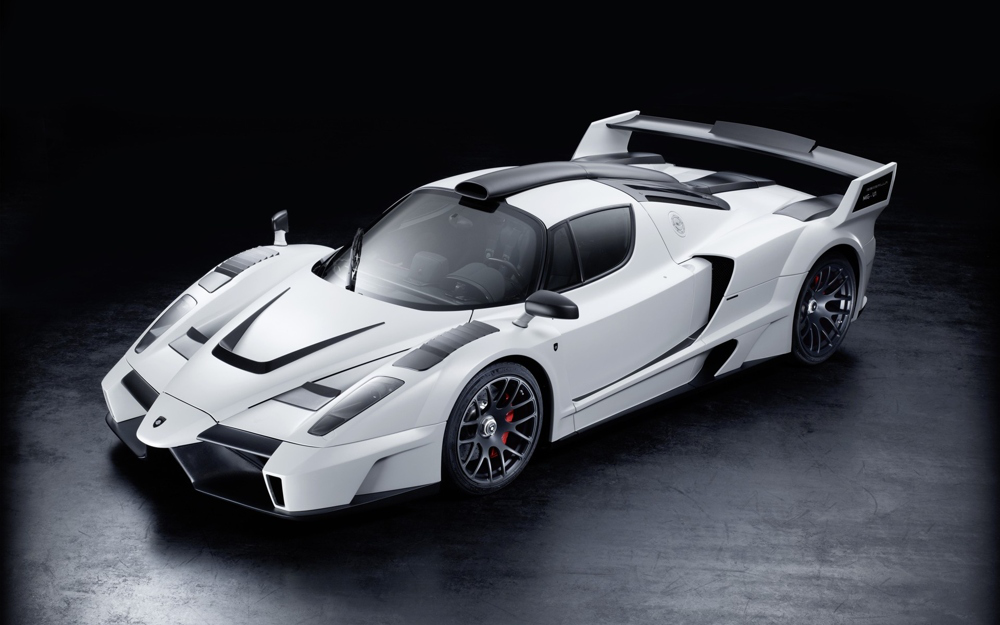

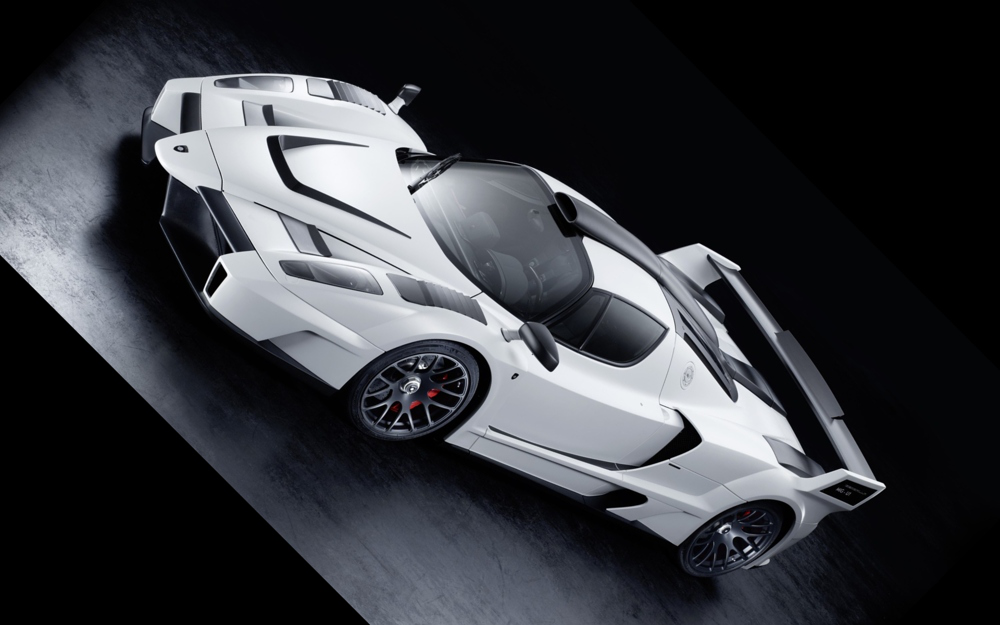

In [14]:
image1 = Image.open("_original.jpg");
image2 = Image.open("rotation3.jpg");
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
I1=transform(image1)
I2=transform(image2)
I1=I1.unsqueeze(dim=0)
I2=I2.unsqueeze(dim=0)
I1,I2=I1.detach().cuda(),I2.detach().cuda()
display(image1)
display(image2)

FeatureExtraction=FeatureExtraction(train_fe=False,
                                                   feature_extraction_cnn='vgg',
                                                   last_layer='pool2',
                                                   normalization=True,
                                                   use_cuda=True)
feature_A = FeatureExtraction(I1).detach()
feature_B = FeatureExtraction(I2).detach()
c,w,h=feature_A.shape[1],feature_A.shape[2],feature_A.shape[3]


Starting optimization with ADAM


<ipython-input-44-bc33df21500e>:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 3)


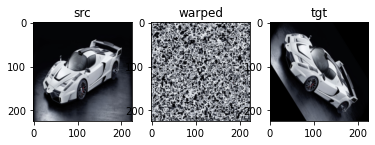

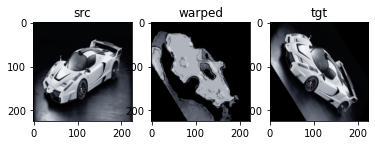

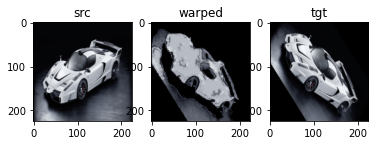

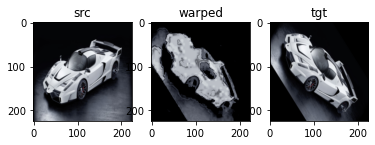

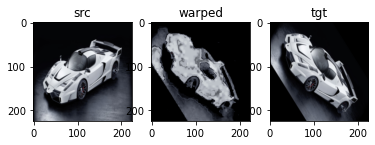

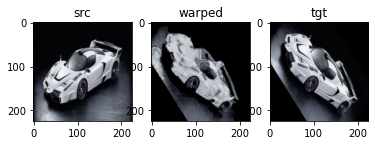

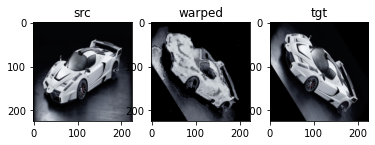

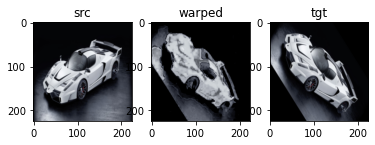

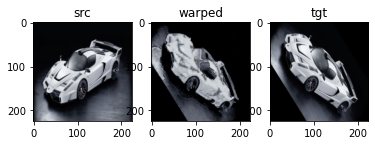

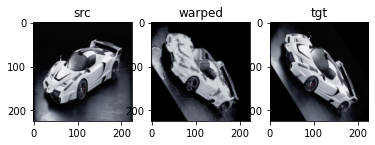

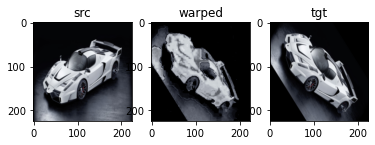

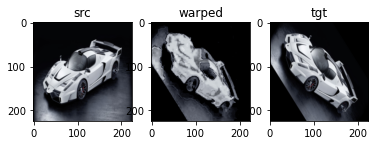

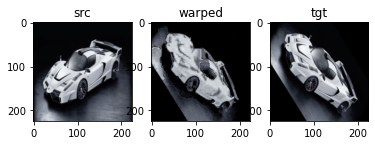

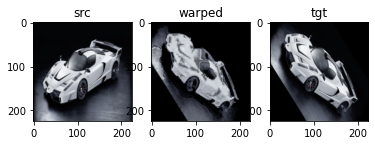

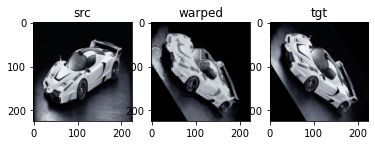

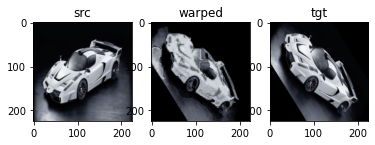

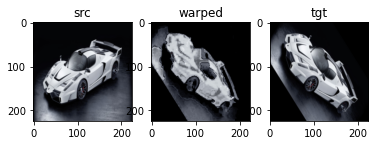

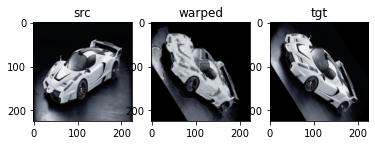

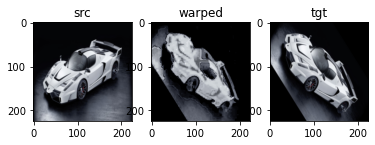

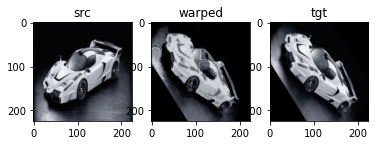

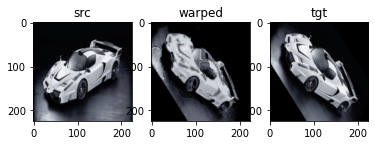

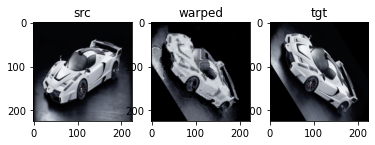

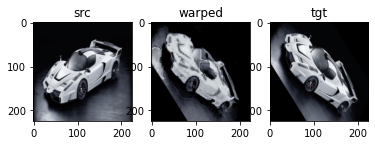

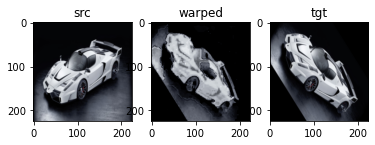

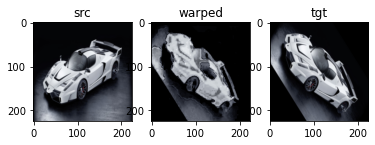

In [48]:
# OPTIMIZE
in_chan=32
dtype = torch.cuda.FloatTensor
mse = torch.nn.MSELoss().type(dtype)
i=0
net=CMDTop(in_chan,bn=True).cuda()
#net=get_net(32,'UNet',pad='zero',upsample_mode='bilinear').cuda()
init_map = torch.FloatTensor(1, 2, w, h).zero_().cuda()
net_input=get_noise(32, 'noise', feature_A[0,0,:].shape,noise_type='u').type(dtype).detach()

net_input_saved = net_input.detach().clone()
p = get_params('net', net, net_input)
optimize('adam', p, closure, 0.01, 5000)

In [14]:
def remap_using_flow_fields(image, disp_x, disp_y, interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT):
    """
    opencv remap : carefull here mapx and mapy contains the index of the future position for each pixel
    not the displacement !
    map_x contains the index of the future horizontal position of each pixel [i,j] while map_y contains the index of the future y
    position of each pixel [i,j]
    All are numpy arrays
    :param image: image to remap, HxWxC
    :param disp_x: displacement on the horizontal direction to apply to each pixel. must be float32. HxW
    :param disp_y: isplacement in the vertical direction to apply to each pixel. must be float32. HxW
    :return:
    remapped image. HxWxC
    """
    h_scale, w_scale=image.shape[:2]

    # estimate the grid
    X, Y = np.meshgrid(np.linspace(0, w_scale - 1, w_scale),
                       np.linspace(0, h_scale - 1, h_scale))
    map_x = (X+disp_x).astype(np.float32)
    map_y = (Y+disp_y).astype(np.float32)
    remapped_image = cv2.remap(image, map_x, map_y, interpolation=interpolation, borderMode=border_mode)

    return remapped_image

In [15]:

def remap_using_correspondence_map(image, map_x, map_y, interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT):
    """
    opencv remap :
    attention: mapping from destination to inverse, the map given must be the inverse
    carefull here map_x and map_y contains the index of the future position for each pixel
    not the displacement !
    mapx contains the index of the future horizontal position of each pixel [i,j] while mapy contains the index of the future y
    position of each pixel [i,j]
    All are numpy arrays
    :param image: image to remap, HxWxC
    :param map_x: horizontal index of remapped position of each pixel. must be float32. HxW
    :param map_y: vertical index of remapped position of each pixel. must be float32. HxW
    :return:
    remapped image. HxWxC
    """
    remapped_image = cv2.remap(image, map_x, map_y, interpolation=interpolation, borderMode=border_mode)
    return remapped_image

Text(0.5, 1.0, 'target image')

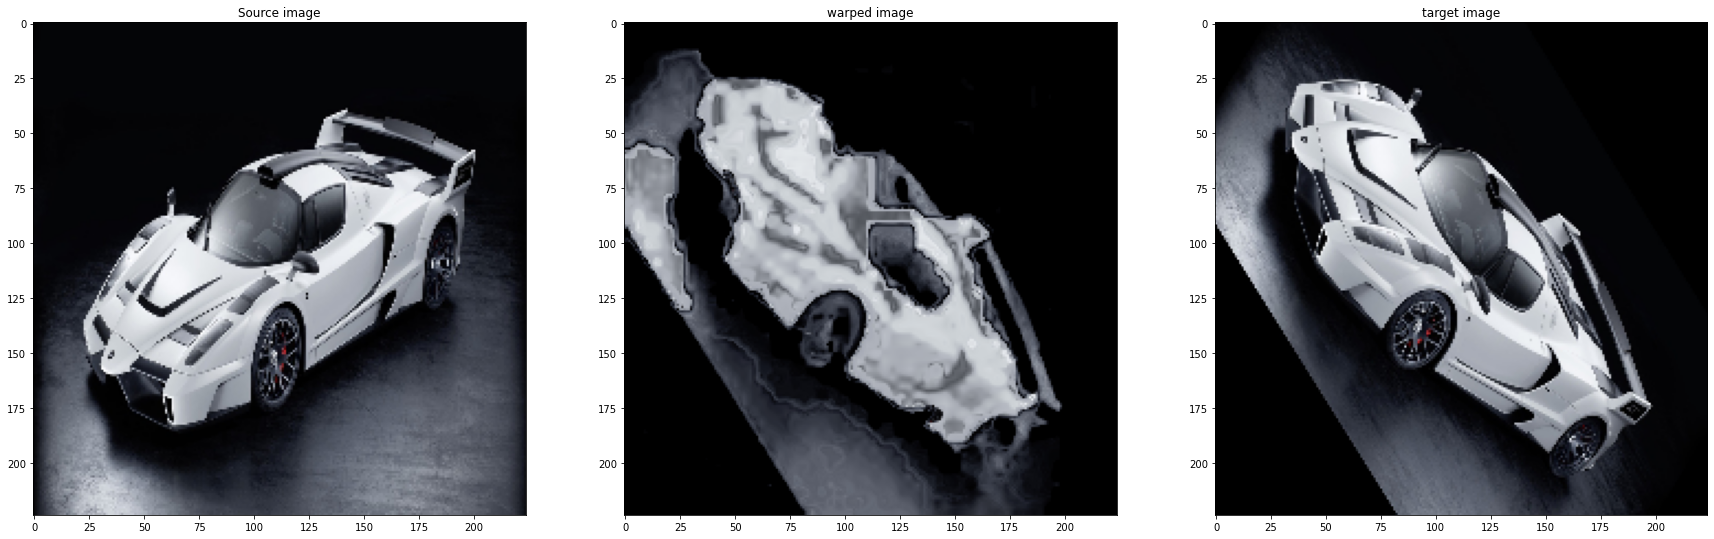

In [49]:
#CMDTop +warp5
image=imageio.imread('_original.jpg')
image2=imageio.imread('rotation3.jpg')
image=cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
image2=cv2.resize(image2, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)


out=net(net_input)
    
    
    
Matching_feature_field=unnormalise_and_convert_mapping_to_flow(out)/1.0

Warped_feature=warp5(feature_A,Matching_feature_field)
  
Matching_image_field=F.interpolate(input=Matching_feature_field, size=(224,224), mode='bilinear')
    
Matching_image_field[:, 0, :, :]=Matching_image_field[:, 0, :, :].clone() *4
Matching_image_field[:, 1, :, :]=Matching_image_field[:, 1, :, :].clone() *4
Warped_image=warp5(I1.detach(),Matching_image_field).squeeze(0).transpose(0, 1).transpose(1, 2).detach().cpu().numpy()

#Warped_image=remap_using_flow_fields(image,Matching_image_field.squeeze()[0].detach().cpu().numpy(),Matching_image_field.squeeze()[1].detach().cpu().numpy())
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(30, 30))
axis1.imshow(image)
axis1.set_title('Source image')
axis2.imshow(Warped_image)
axis2.set_title('warped image')
axis3.imshow(image2)
axis3.set_title('target image')
#number 2 0.9 image loss + 0.1 feature loss


Text(0.5, 1.0, 'target image')

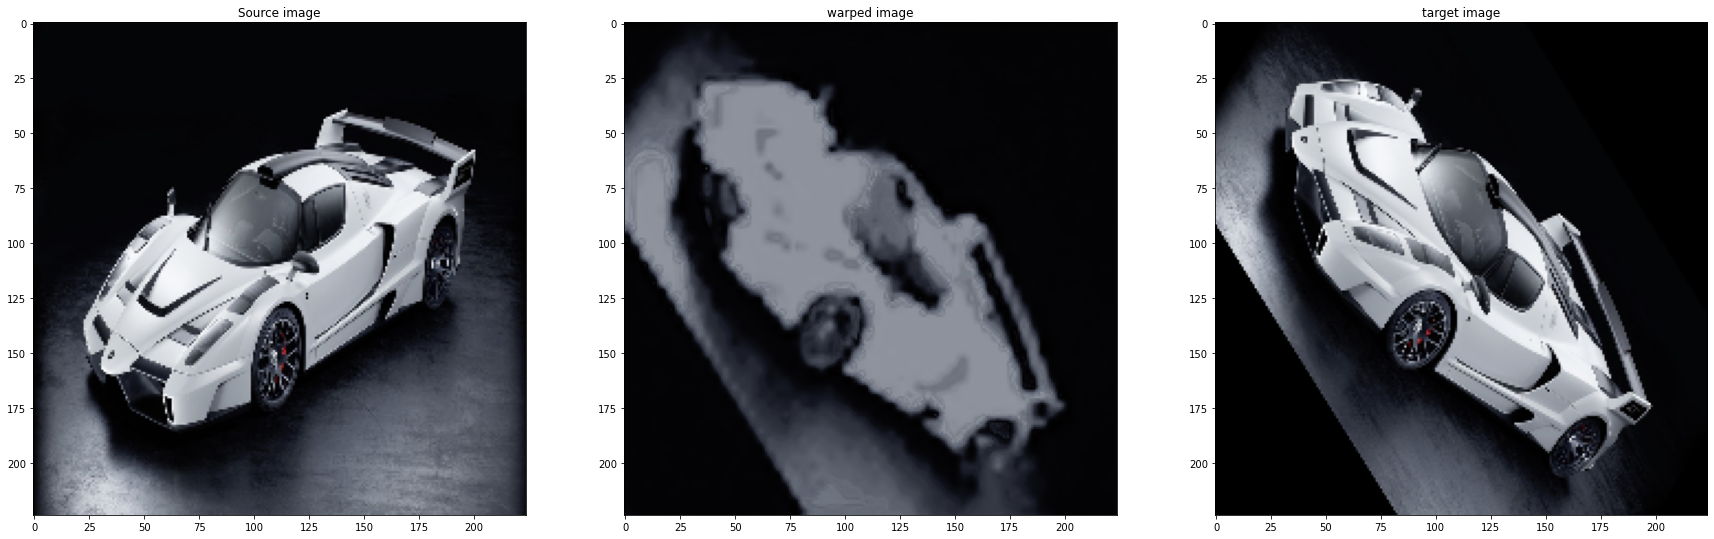

In [47]:
#Unet + warp5
image=imageio.imread('_original.jpg')
image2=imageio.imread('rotation3.jpg')
image=cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
image2=cv2.resize(image2, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)


out=net(net_input)
    
    
    
Matching_feature_field=unnormalise_and_convert_mapping_to_flow(out)/1.0

Warped_feature=warp5(feature_A,Matching_feature_field)
    
    
Matching_image_field=F.interpolate(input=Matching_feature_field, size=(224,224), mode='bilinear')
    
Matching_image_field[:, 0, :, :]=Matching_image_field[:, 0, :, :].clone() *4
Matching_image_field[:, 1, :, :]=Matching_image_field[:, 1, :, :].clone() *4
Warped_image=warp5(I1.detach(),Matching_image_field).squeeze(0).transpose(0, 1).transpose(1, 2).detach().cpu().numpy()

#Warped_image=remap_using_flow_fields(image,Matching_image_field.squeeze()[0].detach().cpu().numpy(),Matching_image_field.squeeze()[1].detach().cpu().numpy())
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(30, 30))
axis1.imshow(image)
axis1.set_title('Source image')
axis2.imshow(Warped_image)
axis2.set_title('warped image')
axis3.imshow(image2)
axis3.set_title('target image')
#number 2 0.9 image loss + 0.1 feature loss


Text(0.5, 1.0, 'target image')

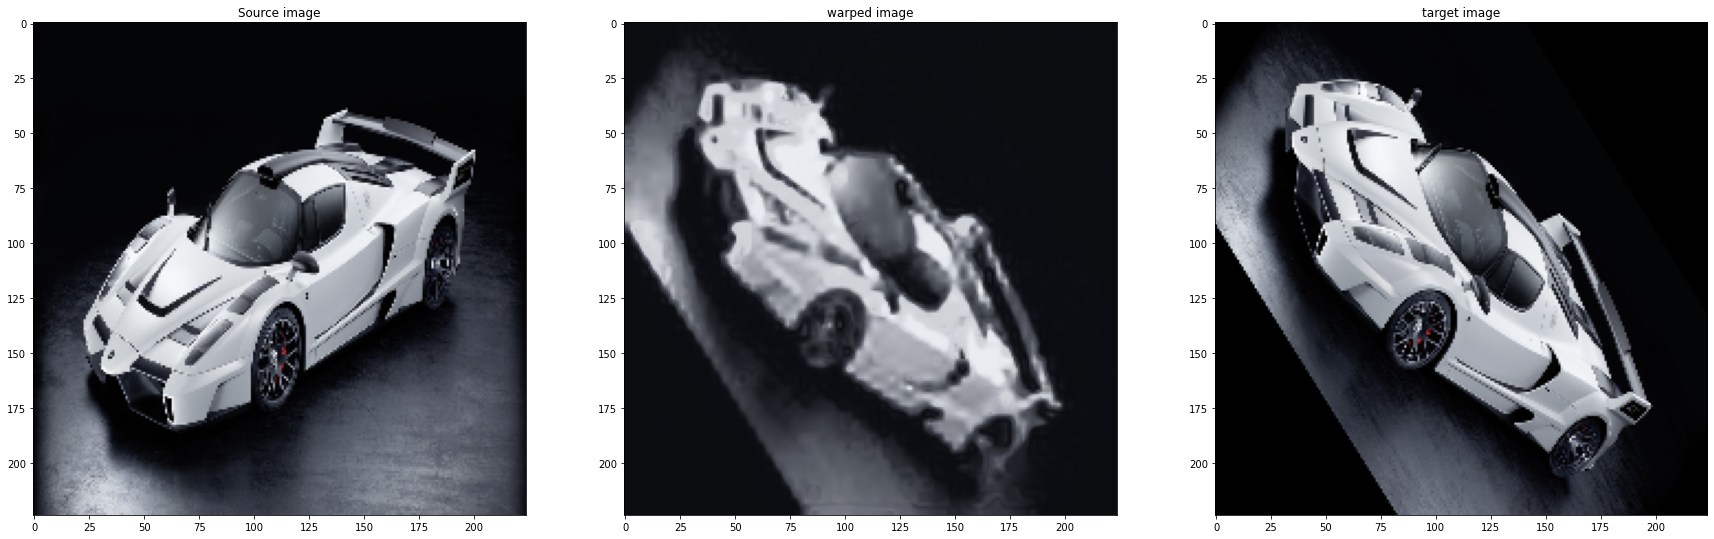

In [23]:
#warp3 + unet
image=imageio.imread('_original.jpg')
image2=imageio.imread('rotation3.jpg')
image=cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
image2=cv2.resize(image2, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
matching=net(net_input)
matching=F.interpolate(matching,size=(224,224),mode='bilinear')

#matching[:,0,:,:]=2*matching[:,0,:,:]-1
#matching[:,1,:,:]=2*matching[:,1,:,:]-1
warped=warp3(I1,matching)


fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(30, 30))
axis1.imshow(image)
axis1.set_title('Source image')
axis2.imshow(warped.transpose(1,2).transpose(2,3).squeeze().detach().cpu().numpy())
axis2.set_title('warped image')
axis3.imshow(image2)
axis3.set_title('target image')

Text(0.5, 1.0, 'target image')

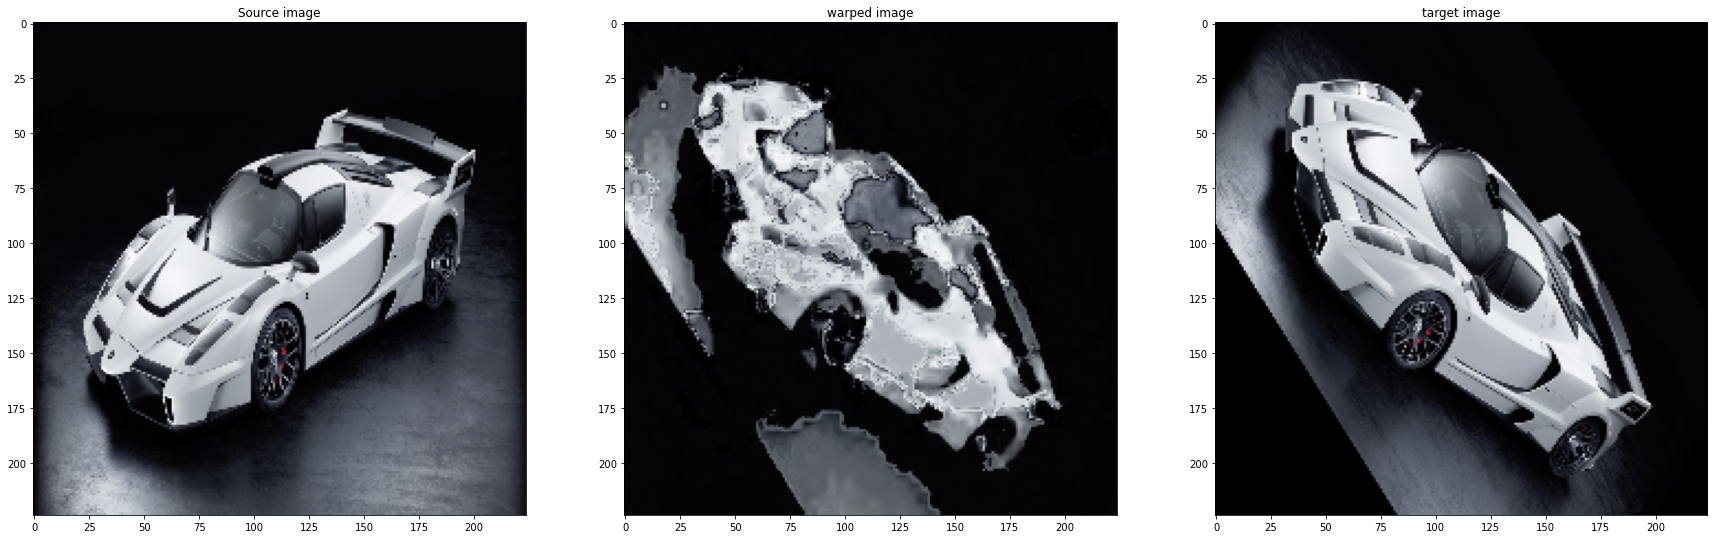

In [32]:
#CMDTop +warp 3
image=imageio.imread('_original.jpg')
image2=imageio.imread('rotation3.jpg')
image=cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
image2=cv2.resize(image2, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
matching=net(net_input)
matching=F.interpolate(matching,size=(224,224),mode='bilinear')

#matching[:,0,:,:]=2*matching[:,0,:,:]-1
#matching[:,1,:,:]=2*matching[:,1,:,:]-1
warped=warp3(I1,matching)


fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(30, 30))
axis1.imshow(image)
axis1.set_title('Source image')
axis2.imshow(warped.transpose(1,2).transpose(2,3).squeeze().detach().cpu().numpy())
axis2.set_title('warped image')
axis3.imshow(image2)
axis3.set_title('target image')